In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

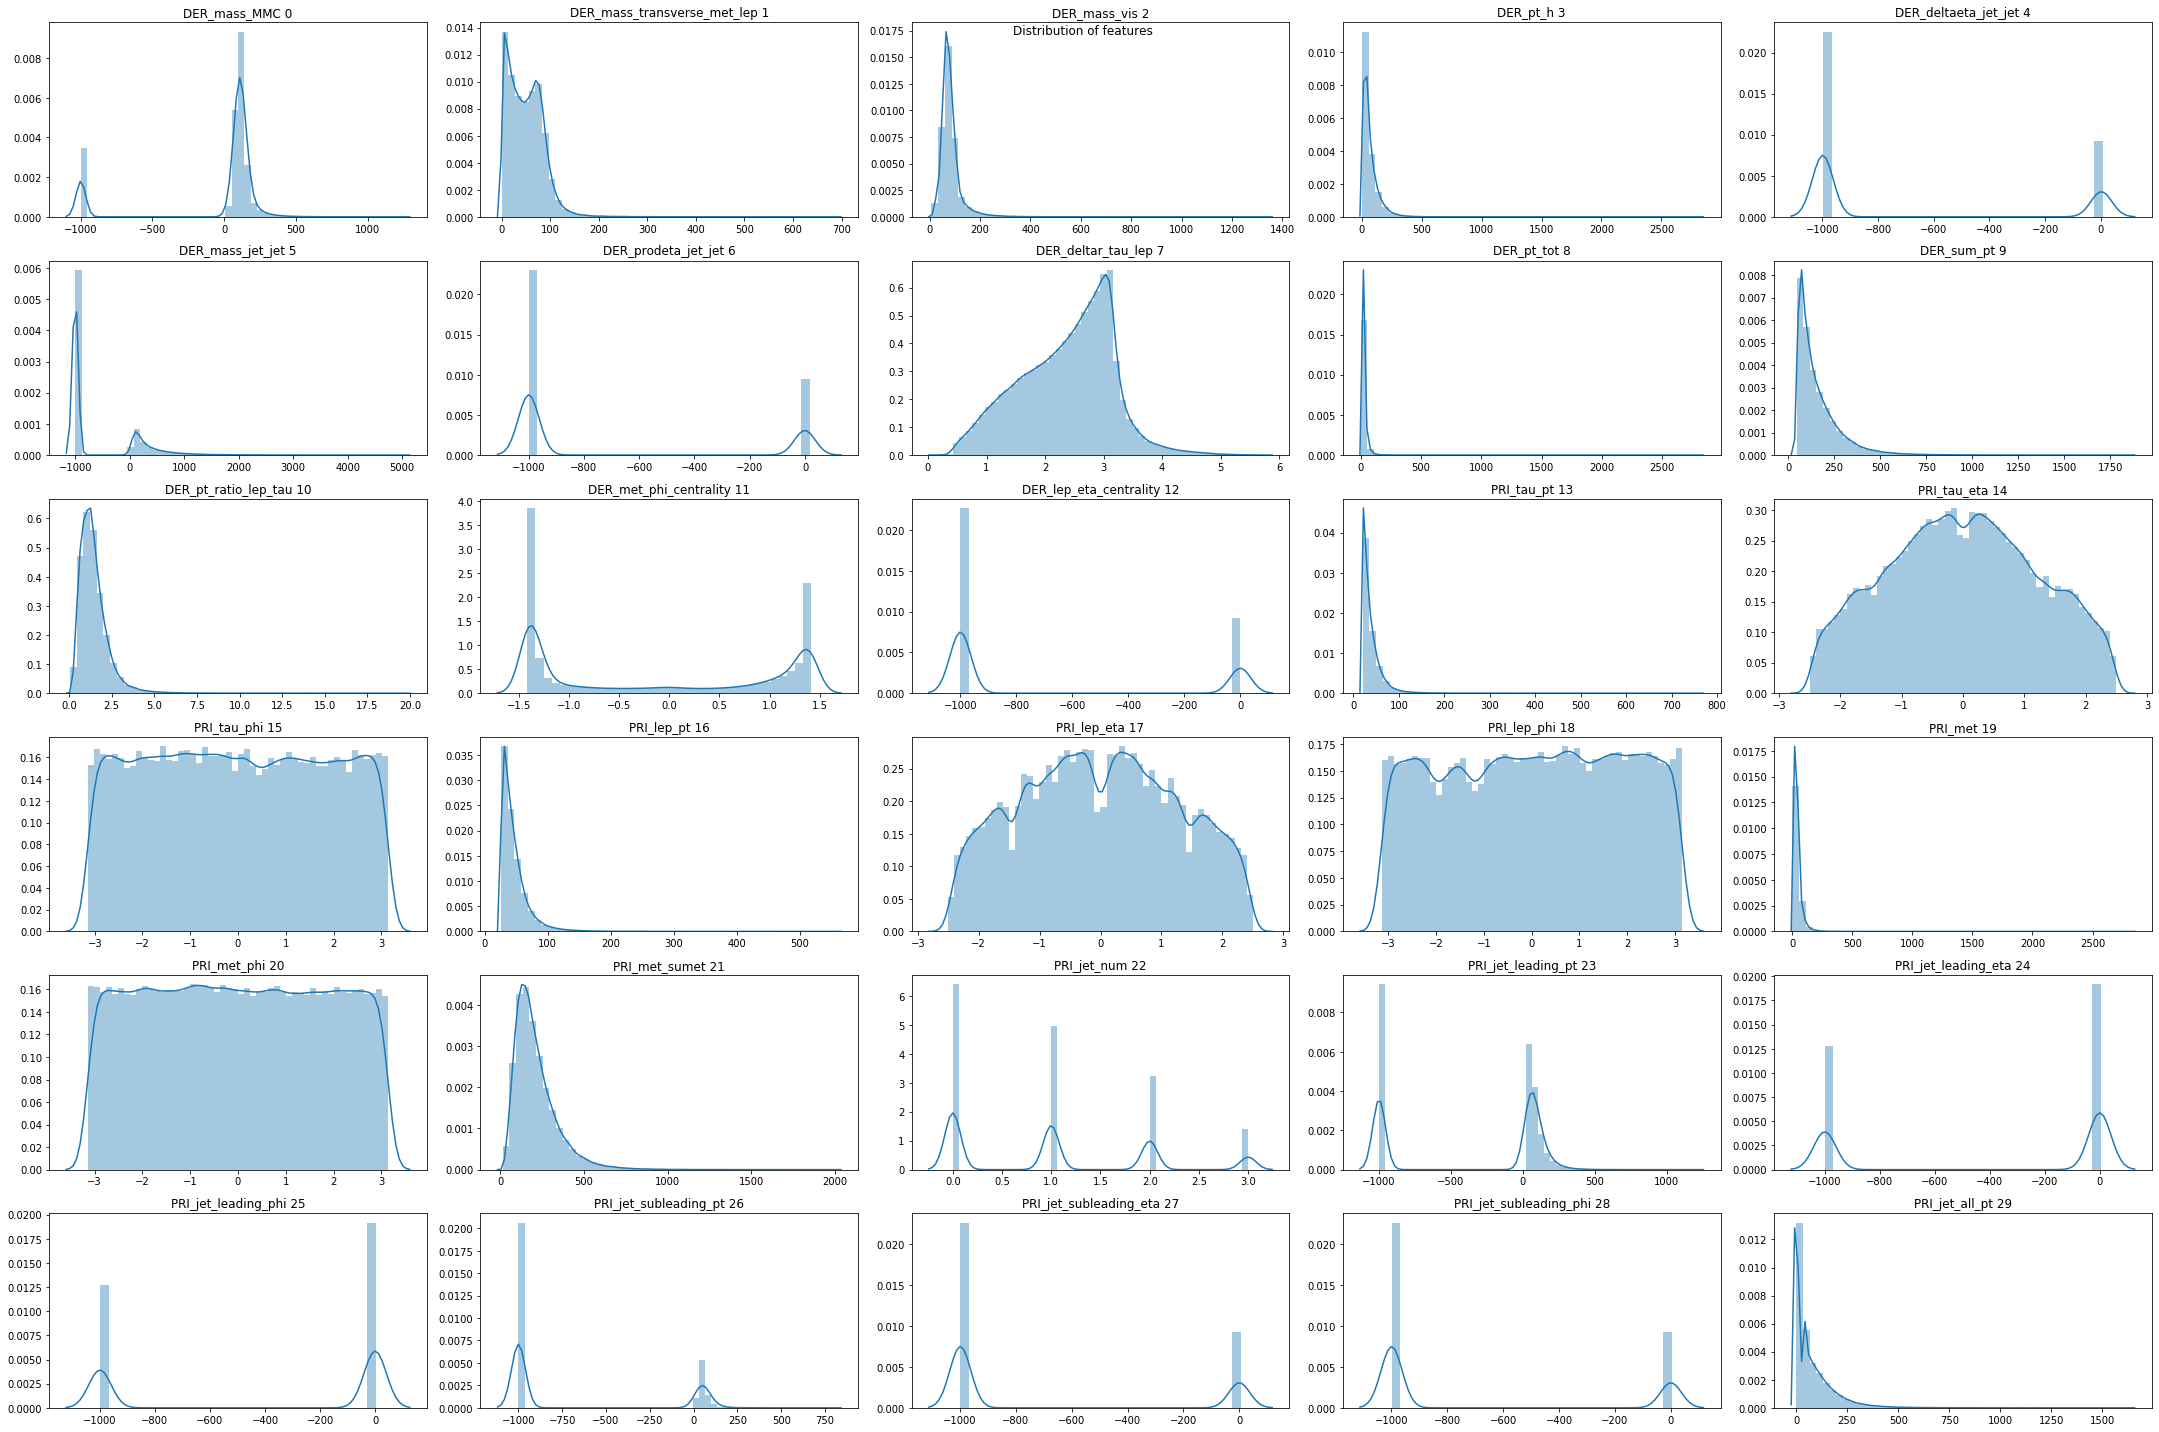

In [3]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(30,20), ncols=5, nrows=6)
i, j = 0, 0
for index, h in enumerate(headers):
    values = tX[:, index]
    sns.distplot(values, ax=ax[i][j])
    ax[i][j].set_title(h + " " +str(index))
    j = (j + 1) % 5
    if j == 0:
        i = (i + 1) % 6
fig.suptitle("Distribution of features")
plt.tight_layout()

Features affected by undefined values:
- `DER_mass_MMC` : undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` : undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` : undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` : undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` : undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` : undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` : undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` : undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` : undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` : undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1), and remove entries with faulty mass (for now).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution, so we can not consider them in our model

In [4]:
jet_column = 22
headers_0_jets = [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 16, 17, 19, 21, 29]
headers_1_jet = headers_0_jets + [23, 24, 25]
headers_more_jets = headers_1_jet + [4, 5, 6, 12, 26, 27, 28]

Trying a Least Square 

In [5]:
tX_wm = tX[np.where(tX[:, 0] > -999)]
y_wm = y[np.where(tX[:, 0] > -999)]

In [6]:
from utils import split_data
tX_0 = tX_wm[np.where(tX_wm[:, 22] == 0)][:, headers_0_jets]
y_0 = y_wm[np.where(tX_wm[:, 22] == 0)]
x_train, y_train, x_test, y_test = split_data(tX_0, y_0, 0.8)

In [58]:
from implementations import least_squares, least_squares_GD, least_squares_SGD, ridge_regression

In [55]:
initial_w = np.zeros((x_train.shape[1],))

weights, loss = least_squares_SGD(y_train, x_train, initial_w, 10000, 1e-5)

Gradient Descent(0/9999): loss=0.5
Gradient Descent(100/9999): loss=0.02463413072108832
Gradient Descent(200/9999): loss=1.3408267250012191
Gradient Descent(300/9999): loss=0.019501259395909954
Gradient Descent(400/9999): loss=3.394212786460124
Gradient Descent(500/9999): loss=0.05815041840660511
Gradient Descent(600/9999): loss=0.21087179499155284
Gradient Descent(700/9999): loss=0.9508037595260891
Gradient Descent(800/9999): loss=0.9210899275218618
Gradient Descent(900/9999): loss=1.0104576904091231
Gradient Descent(1000/9999): loss=0.18645442410238558
Gradient Descent(1100/9999): loss=0.304409291188356
Gradient Descent(1200/9999): loss=0.01790084688799576
Gradient Descent(1300/9999): loss=0.2821378560004234
Gradient Descent(1400/9999): loss=1.3677708413428197e-05
Gradient Descent(1500/9999): loss=0.08797050163066573
Gradient Descent(1600/9999): loss=0.3721807819753934
Gradient Descent(1700/9999): loss=0.09085753645792452
Gradient Descent(1800/9999): loss=0.8318758154643819
Gradient 

In [56]:
y_pred = predict_labels(weights, x_test)

0.737430546144464

In [70]:
weights, loss = ridge_regression(y_train, x_train, 1e-1)

In [71]:
y_pred = predict_labels(weights, x_test)

In [72]:
np.sum(y_pred == y_test) / len(y_pred)

0.7726656728554004

## Generate predictions and save ouput in csv format for submission:

In [126]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [129]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
#create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

array([-1., -1., -1., ...,  1.,  1., -1.])